In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import keras
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from random import randint
from tqdm import tqdm
import cv2

Using TensorFlow backend.


In [2]:
labels = pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
unique_breeds = labels.breed.unique()
print("Number of Class:",len(unique_breeds))

Number of Class: 120


In [4]:
gr_labels = labels.groupby("breed").count()
gr_labels = gr_labels.rename(columns = {"id" : "count"})
gr_labels = gr_labels.sort_values("count", ascending=False)
print("Number of Dogs per Breed:")
gr_labels.head(10)

Number of Dogs per Breed:


,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


Text(0.5,1,'Distribution of Dog breeds')

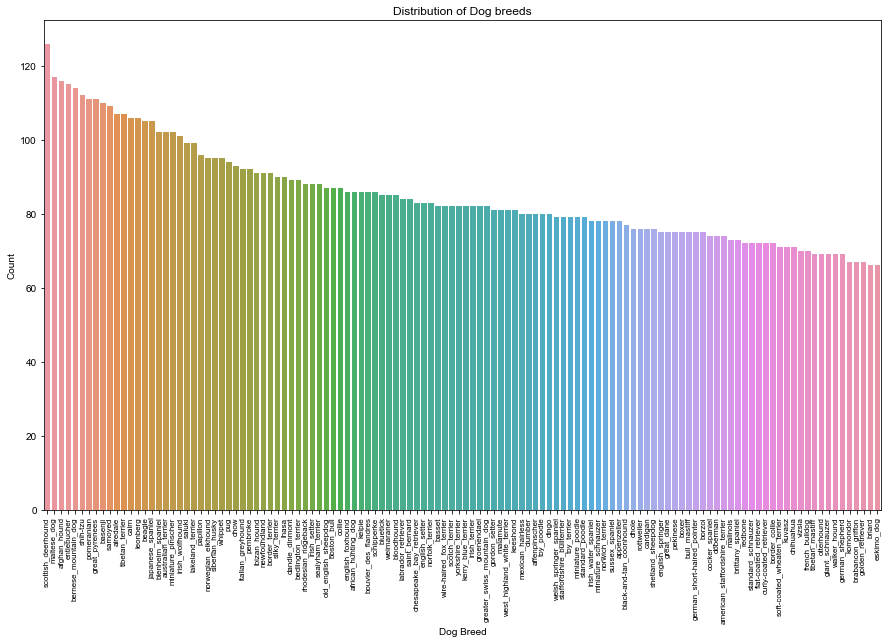

In [5]:

yy = pd.value_counts(labels['breed'])

fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of Dog breeds')

In [6]:
train_path = 'data_gen/train'
valid_path = 'data_gen/validation'
test_path = 'data_gen/test'

In [60]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),batch_size=16)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224),batch_size=16)
#test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),batch_size=16)

Found 7213 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.


In [16]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [19]:
image_paths_train = path_join(train_path, train_batches.filenames)
image_paths_valid = path_join(valid_path, valid_batches.filenames)


In [21]:
cls_train = train_batches.classes
cls_valid = valid_batches.classes

In [25]:
class_names = list(train_batches.class_indices.keys())

In [26]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

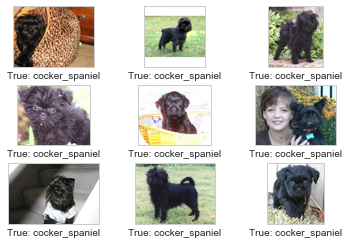

In [27]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

# VGG16 Model

In [34]:
vgg16_model = keras.applications.vgg16.VGG16?

In [28]:
vgg16_model = keras.applications.vgg16.VGG16()

In [29]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [30]:
type(vgg16_model)

keras.engine.training.Model

In [31]:
vgg16_model.layers.pop()

In [32]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [33]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [35]:
for layer in model.layers:
    layer.trainable = False

In [36]:
model.add(Dense(120, activation='softmax'))

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Train the fine-tuned VGG16 model

In [39]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit_generator(train_batches,validation_data=valid_batches,epochs=5,verbose=2)


Epoch 1/5
 - 326s - loss: 5.0261 - acc: 0.3213 - val_loss: 4.7974 - val_acc: 0.3898
Epoch 2/5
 - 334s - loss: 2.0798 - acc: 0.6437 - val_loss: 4.5620 - val_acc: 0.4121
Epoch 3/5
 - 640s - loss: 1.1202 - acc: 0.7805 - val_loss: 4.5811 - val_acc: 0.4374
Epoch 4/5
 - 345s - loss: 0.7179 - acc: 0.8581 - val_loss: 4.7371 - val_acc: 0.4384
Epoch 5/5
 - 349s - loss: 0.4988 - acc: 0.8978 - val_loss: 4.9408 - val_acc: 0.4294


In [41]:
model.save("Dog_breed_vgg16.h5")

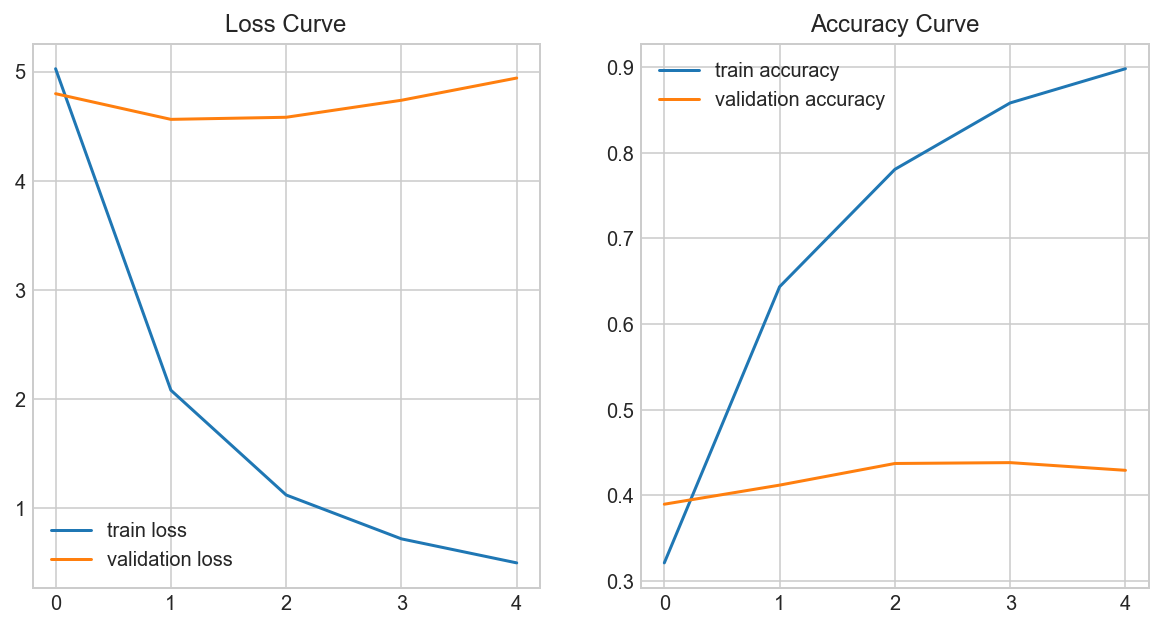

In [52]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.set_title('Loss Curve')
ax1.plot(model.history.history['loss'])
ax1.plot(model.history.history['val_loss'])
ax1.legend(['train loss', 'validation loss'])

ax2.set_title('Accuracy Curve')
ax2.plot(model.history.history['acc'])
ax2.plot(model.history.history['val_acc'])
ax2.legend(['train accuracy', 'validation accuracy'])


In [58]:
def readImgResize(name,path):
    img = cv2.imread(path+name)
    img = cv2.resize(img,(224,224))
    return image.img_to_array(img)

In [ ]:
from keras.models import load_model

te = os.listdir("data_gen/test/")
te_in = np.zeros((len(te),224, 224, 3))
for num, i in enumerate(te):
    img = readImgResize(i,path="data_gen/test/")/255
    te_in[num]=img
    
pred = model.predict(te_in)

In [ ]:
submission = pd.DataFrame(pred , columns =le.classes_.tolist())
submission["id"]=[i.split(".")[0] for i in os.listdir("data_gen/test/")]
submission = submission[["id"]+submission.columns[:-1].tolist()]